In [1]:
## anaconda3 (Python 3.9.13) Kernel

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [2]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file);

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_40555/3735753696.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


In [3]:
len(pairsOutcome)

17

In [4]:
import csv

with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]


top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]

print("10 clustered pair trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Pair: {key}, Value: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

10 clustered pair trades:
1. Pair: 6503 JP Equity 7269 JP Equity, Value: 1.33
2. Pair: 6326 JP Equity 6954 JP Equity, Value: 1.19
3. Pair: 8053 JP Equity 8058 JP Equity, Value: 0.52
4. Pair: 4901 JP Equity 9613 JP Equity, Value: 1.10
5. Pair: 6988 JP Equity 7267 JP Equity, Value: 0.65
6. Pair: 4901 JP Equity 6702 JP Equity, Value: -0.34
7. Pair: 4684 JP Equity 7832 JP Equity, Value: 0.89
8. Pair: 7267 JP Equity 8306 JP Equity, Value: 1.16
9. Pair: 7267 JP Equity 8801 JP Equity, Value: 0.64
10. Pair: 4519 JP Equity 7532 JP Equity, Value: 1.14


In [5]:
working_pair = pairsOutcome[top_keys[0]]
working_pair = working_pair.iloc[261:]
working_pair = working_pair.iloc[:, :-2]
working_pair

,spread,mid,1sd high,1sd low,2sd high,2sd low,position,6503 JP Equity position,7269 JP Equity position
Date,,,,,,,,,
1/1/2014,166.950061,-89.698832,39.560998,-218.958661,168.820828,-348.218491,-1,-1,1
2/1/2014,166.950061,-87.901542,41.641394,-217.444479,171.184331,-346.987416,-1,-1,1
3/1/2014,166.950061,-86.104253,43.696194,-215.904701,173.496642,-345.705148,-1,-1,1
6/1/2014,165.770330,-84.311467,45.712333,-214.335267,175.736132,-344.359066,-1,-1,1
7/1/2014,148.384234,-82.535893,47.477046,-212.548831,177.489984,-342.561770,-1,-1,1
...,...,...,...,...,...,...,...,...,...
27/5/2024,711.312149,312.114302,519.582968,104.645636,727.051634,-102.823030,-1,-1,1
28/5/2024,729.471175,313.747398,522.810854,104.683941,731.874311,-104.379515,-1,-1,1
29/5/2024,616.692335,314.853872,524.752129,104.955615,734.650386,-104.942642,-1,-1,1


In [6]:
def count_consecutive(col):
  """
  This function counts the length of consecutive -1 and 1 in a pandas Series.

  Args:
      col: The pandas Series containing the position values.

  Returns:
      A dictionary containing two DataFrames:
          - 'minus_one_consecutive': DataFrame with lengths of consecutive -1.
          - 'plus_one_consecutive': DataFrame with lengths of consecutive 1.
  """
  minus_one_consecutive = []
  plus_one_consecutive = []
  count = 0
  prev = None
  for val in col:
    if val == prev:
      count += 1
    else:
      if prev == -1:
        minus_one_consecutive.append(count)
      elif prev == 1:
        plus_one_consecutive.append(count)
      count = 1
    prev = val
  if prev == -1:
    minus_one_consecutive.append(count)
  elif prev == 1:
    plus_one_consecutive.append(count)

  return {
      'minus_one_consecutive': pd.DataFrame(minus_one_consecutive),
      'plus_one_consecutive': pd.DataFrame(plus_one_consecutive)
  }


In [7]:

# Get results
consecutive_lengths = count_consecutive(working_pair['position'])


In [8]:
consecutive_lengths

{'minus_one_consecutive':       0
 0    21
 1     1
 2     9
 3     1
 4     4
 ..   ..
 96    6
 97   10
 98    1
 99    1
 100   5
 
 [101 rows x 1 columns],
 'plus_one_consecutive':      0
 0    1
 1    3
 2    2
 3    1
 4    1
 5   17
 6    9
 7    8
 8    5
 9    1
 10   5
 11   6
 12   3
 13   5
 14   2
 15  19
 16   5
 17   6
 18  10
 19  12
 20   6
 21   3
 22   1
 23  12
 24   2
 25   4
 26   3
 27   1
 28   1
 29   2
 30   1
 31   9
 32  12
 33   6
 34   4
 35   7
 36   2
 37   1
 38  15
 39   9
 40  12
 41   5
 42  19
 43   1
 44   1
 45  14
 46   3
 47  15
 48   3
 49   8
 50   9
 51   1
 52   1}

In [9]:
consecutive_lengths['minus_one_consecutive'].describe()


,0
count,101.000000
mean,5.772277
std,6.344890
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,37.000000


In [10]:
consecutive_lengths['plus_one_consecutive'].describe()


,0
count,53.000000
mean,5.924528
std,5.117275
min,1.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,19.000000


In [11]:
consecutive_lengths['minus_one_consecutive'].values.sum()

583

In [12]:
consecutive_lengths['plus_one_consecutive'].values.sum()

314

In [13]:
consecutive_lengths['minus_one_consecutive'].values.sum() + consecutive_lengths['plus_one_consecutive'].values.sum()

897

taking position 1038 out of 2718 days of trading

In [14]:
# Count changes in position values
position_changes = (working_pair['position'] != working_pair['position'].shift(1)).sum()

# Print result
print("\nTotal number of position changes:", position_changes)



Total number of position changes: 307


In [15]:
f"over {2718/261:.1f} years means {350/(2718/261):.1f} ave trades per year"

'over 10.4 years means 33.6 ave trades per year'

In [16]:
working_pair.isna().sum()

spread                     0
mid                        0
1sd high                   0
1sd low                    0
2sd high                   0
2sd low                    0
position                   0
6503 JP Equity position    0
7269 JP Equity position    0
dtype: int64

```   
df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1 
df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1
```
### Level 1

above is the line where we assign some weightage to the position size. 

1. If we can assign a challenge to the Q learner to let it decide how much to make this number for 10 pairs.
2. Then we measure the total cum pnl 
3. Use that data to give a reward function

### Level 2
1. Only get learner to size when entering a trade. only give the Q learner state on the trade date

### Level 3
1. Daily sizing of trade

In [17]:
working_pair

,spread,mid,1sd high,1sd low,2sd high,2sd low,position,6503 JP Equity position,7269 JP Equity position
Date,,,,,,,,,
1/1/2014,166.950061,-89.698832,39.560998,-218.958661,168.820828,-348.218491,-1,-1,1
2/1/2014,166.950061,-87.901542,41.641394,-217.444479,171.184331,-346.987416,-1,-1,1
3/1/2014,166.950061,-86.104253,43.696194,-215.904701,173.496642,-345.705148,-1,-1,1
6/1/2014,165.770330,-84.311467,45.712333,-214.335267,175.736132,-344.359066,-1,-1,1
7/1/2014,148.384234,-82.535893,47.477046,-212.548831,177.489984,-342.561770,-1,-1,1
...,...,...,...,...,...,...,...,...,...
27/5/2024,711.312149,312.114302,519.582968,104.645636,727.051634,-102.823030,-1,-1,1
28/5/2024,729.471175,313.747398,522.810854,104.683941,731.874311,-104.379515,-1,-1,1
29/5/2024,616.692335,314.853872,524.752129,104.955615,734.650386,-104.942642,-1,-1,1


In [18]:
with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]

top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]
rollingWindow = 262
cutLossSd = 2

for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_40555/3045906102.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


In [49]:
workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[pair].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['spread','1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

workingPairOutcome[top_keys[5]][-5:]

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0]])

In [50]:
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]
rollingWindow = 262
cutLossSd = 2

for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[pair].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

workingPairOutcome[top_keys[5]][-5:]  


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_40555/1036547325.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


array([[2.00028887, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.6859092 , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.52197973, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.40723813, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.46852476, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ]])

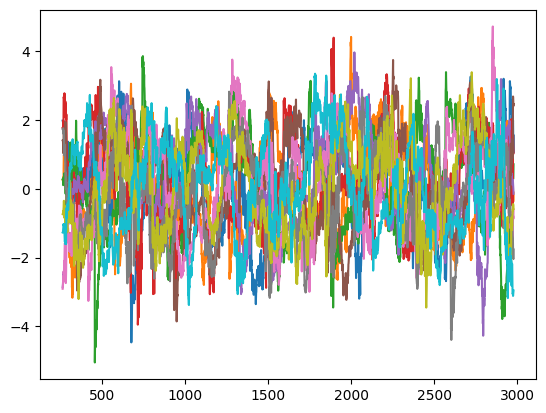

In [51]:
for i in range(len(top_keys)):
    plt.plot(workingPairOutcome[top_keys[i]][:,0])

In [52]:
top_keys[1], top_keys[5]

('6326 JP Equity 6954 JP Equity', '4901 JP Equity 6702 JP Equity')

In [53]:
workingPairOutcome[top_keys[5]][:,0] == workingPairOutcome[top_keys[1]][:,0]

array([False, False, False, ..., False, False, False])